In [1]:
# %%capture cap
!pip install -q ipywidgets
!pip install -q autogluon scikit-learn==1.5.2 
!apt-get install -q -y graphviz graphviz-dev && pip install -q pydot
!pip install -q pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 9.2 MB/s eta 0:00

In [2]:
import torch
import os
import pydot

import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 500)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

print("Packages import succesful!")

Packages import succesful!


In [3]:
### Load Data ###
PATH = '/kaggle/input/playground-series-s5e12/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv").drop('id', axis=1)

TARGET = train.columns[-1]
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = '/kaggle/input/diabetes-health-indicators-dataset/'
orig = pd.read_csv(ORIG_PATH+'diabetes_dataset.csv')[BASE+[TARGET]]

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (700000, 25)
Test shape: (300000, 24)
Original shape: (100000, 25)

Total Numerical: 18
Total Categorical: 6
Total base features: 24


In [4]:
## -- Define categories for OHE --
CAT_COLS = [c for c in BASE if train[c].dtype=='object' or train[c].nunique() <= 0.01*len(train)]
print(f"ℹ️ Features for TE: {len(CAT_COLS)} -> {CAT_COLS}")

ℹ️ Features for TE: 24 -> ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


In [5]:
# ROUND = []
# for col in tqdm(['annual_income', 'loan_amount']):
#     for r in [-3, -2, -1, 0]:
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype(int)
#         test[n] = test[col].round(r).astype(int)
#         orig[n] = test[col].round(r).astype(int)
#         ROUND.append(n)

# print(f'{len(ROUND)} ROUND Features created.')
# print(train[ROUND].nunique())

# DIGITS = []
# for col in tqdm(['debt_to_income_ratio']):
#     for d in range(1, 4):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# for col in tqdm(['interest_rate']):
#     for d in range(1, 3):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# print(f'{len(DIGITS)} Features DIGITS extracted.')
# print(train[DIGITS].nunique())

# INTER = []
# for col1, col2 in tqdm(list(combinations(CAT_COLS+DIGITS, 2)), desc="Pairwise"):
#     new_col = f"{col1}-|-{col2}"
#     train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
#     test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
#     orig[new_col] = orig[col1].astype(str) + '_' + orig[col2].astype(str)
#     INTER.append(new_col)

# print(f"Ineraction Features: {len(INTER)}")

In [6]:
# ORIG = []

# for col in tqdm(BASE):
#     # MEAN
#     mean_map = orig.groupby(col)[TARGET].mean()
#     mean_col = f"OTE_{col}_mean"
#     mean_map.name = mean_col

#     train = train.merge(mean_map, on=col, how='left')
#     test = test.merge(mean_map, on=col, how='left')
#     ORIG.append(mean_col)

#     # COUNT
#     count_col = f"OTE_{col}_count"
#     count_map = orig.groupby(col).size().reset_index(name=count_col)

#     train = train.merge(count_map, on=col, how='left')
#     test = test.merge(count_map, on=col, how='left')
#     ORIG.append(count_col)

# print(len(ORIG), 'Orig Features Created!!')

In [7]:
combined = pd.concat([train, test, orig], ignore_index=True)

# ## 1. CONVERT ALL NUMS TO CATEGORY --
# for c in NUMS:
#     combined[c] = combined[c].astype(str)

## 2. DUPLICATE ALL NUMS AND CONVERT TO CATEGORY --
for c in NUMS:
    combined[f'cat_{c}'] = combined[c].astype(str)

# ## 3. CONVERT ALL CATS TO NUMERICS --
# for c in CATS:
#     combined[c] = combined[c].factorize()[0]

train = combined[:len(train)]
test  = combined[len(train):len(train)+len(test)]
orig  = combined[-len(orig):]

orig.shape, train.shape, test.shape

((100000, 43), (700000, 43), (300000, 43))

In [8]:
display(train.head())
train.info()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes,cat_age,cat_alcohol_consumption_per_week,cat_physical_activity_minutes_per_week,cat_diet_score,cat_sleep_hours_per_day,cat_screen_time_hours_per_day,cat_bmi,cat_waist_to_hip_ratio,cat_systolic_bp,cat_diastolic_bp,cat_heart_rate,cat_cholesterol_total,cat_hdl_cholesterol,cat_ldl_cholesterol,cat_triglycerides,cat_family_history_diabetes,cat_hypertension_history,cat_cardiovascular_history
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,0,0,0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,0,0,0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,0,0,0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,0,1,0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0,54,1,55,5.7,6.2,5.1,28.8,0.9,108,60,85,206,49,131,124,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     700000 non-null  int64  
 1   alcohol_consumption_per_week            700000 non-null  int64  
 2   physical_activity_minutes_per_week      700000 non-null  int64  
 3   diet_score                              700000 non-null  float64
 4   sleep_hours_per_day                     700000 non-null  float64
 5   screen_time_hours_per_day               700000 non-null  float64
 6   bmi                                     700000 non-null  float64
 7   waist_to_hip_ratio                      700000 non-null  float64
 8   systolic_bp                             700000 non-null  int64  
 9   diastolic_bp                            700000 non-null  int64  
 10  heart_rate                              7000

In [9]:
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 1000000 to 1099999
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     100000 non-null  int64  
 1   alcohol_consumption_per_week            100000 non-null  int64  
 2   physical_activity_minutes_per_week      100000 non-null  int64  
 3   diet_score                              100000 non-null  float64
 4   sleep_hours_per_day                     100000 non-null  float64
 5   screen_time_hours_per_day               100000 non-null  float64
 6   bmi                                     100000 non-null  float64
 7   waist_to_hip_ratio                      100000 non-null  float64
 8   systolic_bp                             100000 non-null  int64  
 9   diastolic_bp                            100000 non-null  int64  
 10  heart_rate                           

In [10]:
MODELS_PATH = "/kaggle/working/AG_DIABETES_models/"
# !rm -r {MODELS_PATH}

In [11]:
from autogluon.tabular import TabularPredictor

In [12]:
## -- RUN 1: Use train data -- 
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "binary",
          eval_metric = "roc_auc",
                 path = MODELS_PATH,
    ).fit(
                   train_data = train,
                      presets = "best",
                num_bag_folds = 10,
             dynamic_stacking = False,
             num_stack_levels = 1,
                   time_limit = 3600*6,
                   # auto_stack = False,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count()},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Memory Avail:       28.35 GB / 31.35 GB (90.4%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 21600s
AutoGluon will save models to "/kaggle/working/AG_DIABETES_models"
Train Data Rows:    700000
Train Data Columns: 42
Label Column:       diagnosed_diabetes
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGe

In [13]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}\n") 

## -- RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 21
-> Best model   : WeightedEnsemble_L3



,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.731578,roc_auc,451.547717,20701.888938,0.187138,110.352291,3,True,21
1,WeightedEnsemble_L2,0.731509,roc_auc,91.519714,12185.097341,0.194255,47.898600,2,True,11
2,CatBoost_BAG_L2,0.731490,roc_auc,272.716286,18138.577214,6.559083,4000.133221,2,True,16
3,LightGBM_BAG_L2,0.730893,roc_auc,273.023355,14298.305300,6.866152,159.861307,2,True,13
4,LightGBMXT_BAG_L2,0.730696,roc_auc,276.423930,14317.098375,10.266727,178.654381,2,True,12
5,ExtraTreesEntr_BAG_L2,0.730527,roc_auc,306.484875,14308.760183,40.327672,170.316189,2,True,18
6,NeuralNetFastAI_BAG_L2,0.730502,roc_auc,289.409729,14491.177838,23.252526,352.733845,2,True,19
7,ExtraTreesGini_BAG_L2,0.730490,roc_auc,308.292112,14314.121727,42.134909,175.677734,2,True,17
8,XGBoost_BAG_L2,0.730427,roc_auc,276.661059,14377.399605,10.503856,238.955611,2,True,20
9,CatBoost_BAG_L1,0.730095,roc_auc,13.026124,10334.518569,13.026124,10334.518569,1,True,5


In [14]:
# -- RUN 2: Use original data as extra learning input --
predictor.fit_pseudolabel(
                orig,
                use_ensemble = True,
                fit_ensemble = True,
                time_limit   = 3600*5,
)

Fitting predictor using the provided pseudolabeled examples as extra training data...
Fitting 108 L1 models, fit_strategy="sequential" ...
Fitting model: LightGBMXT_BAG_L1_PSEUDO ... Training model for up to 18000.00s of the 17999.98s of remaining time.
	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=2.43%)
	0.7295	 = Validation score   (roc_auc)
	410.24s	 = Training   runtime
	41.49s	 = Validation runtime
Fitting model: LightGBM_BAG_L1_PSEUDO ... Training model for up to 17581.82s of the 17581.80s of remaining time.
	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=2.43%)
	0.7289	 = Validation score   (roc_auc)
	348.52s	 = Training   runtime
	27.25s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1_PSEUDO ... Training model for up to 17226.04s of the 17226.02s of remaining time.
	0.7047	 = Validation score   (roc_auc)


In [15]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}\n") 

## -- RUN 2 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 33
-> Best model   : WeightedEnsemble_L3Best



,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3Best,0.731814,roc_auc,432.937659,34482.130398,0.213783,144.924999,3,True,33
1,WeightedEnsemble_L3,0.731578,roc_auc,451.547717,20701.888938,0.187138,110.352291,3,True,21
2,WeightedEnsemble_L2,0.731509,roc_auc,91.519714,12185.097341,0.194255,47.898600,2,True,11
3,CatBoost_BAG_L2,0.731490,roc_auc,272.716286,18138.577214,6.559083,4000.133221,2,True,16
4,WeightedEnsemble_L2_PSEUDO,0.731241,roc_auc,102.955057,15240.545516,0.190003,49.919037,2,True,32
5,LightGBM_BAG_L2,0.730893,roc_auc,273.023355,14298.305300,6.866152,159.861307,2,True,13
6,LightGBMXT_BAG_L2,0.730696,roc_auc,276.423930,14317.098375,10.266727,178.654381,2,True,12
7,ExtraTreesEntr_BAG_L2,0.730527,roc_auc,306.484875,14308.760183,40.327672,170.316189,2,True,18
8,NeuralNetFastAI_BAG_L2,0.730502,roc_auc,289.409729,14491.177838,23.252526,352.733845,2,True,19
9,ExtraTreesGini_BAG_L2,0.730490,roc_auc,308.292112,14314.121727,42.134909,175.677734,2,True,17


In [16]:
## -- Create folder directory to save predictions --
SAVE_PATH = '/kaggle/working/AG_DIABETES_preds/'
!mkdir {SAVE_PATH}

In [17]:
%%time
## -- Generate predictions for all models --
ag_multi_test_proba = predictor.predict_proba_multi(test, as_multiclass=False)

## -- Save TEST predictions of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '')
    final_test_data[k_renamed] = v

FILE_NAME = 'ag_diabetes.parquet'
file_name = f"{SAVE_PATH}pred_ag_diabetes.parquet"

final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(file_name, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/33 [00:00<?, ?it/s]

CPU times: user 27min 21s, sys: 22.2 s, total: 27min 43s
Wall time: 13min 12s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,LightGBMLargeBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,WeightedEnsembleL3,LightGBMXTBAGL1PSEUDO,LightGBMBAGL1PSEUDO,RandomForestGiniBAGL1PSEUDO,RandomForestEntrBAGL1PSEUDO,CatBoostBAGL1PSEUDO,ExtraTreesGiniBAGL1PSEUDO,ExtraTreesEntrBAGL1PSEUDO,NeuralNetFastAIBAGL1PSEUDO,XGBoostBAGL1PSEUDO,LightGBMLargeBAGL1PSEUDO,WeightedEnsembleL2PSEUDO,WeightedEnsembleL3Best
700000,0.461216,0.463329,0.525045,0.537416,0.481673,0.533644,0.540919,0.474407,0.552614,0.578951,0.472248,0.458828,0.464410,0.464554,0.448744,0.463142,0.462036,0.466946,0.460746,0.604568,0.481540,0.454026,0.441687,0.560622,0.514647,0.460417,0.536640,0.524299,0.480747,0.538749,0.519301,0.460281,0.521161
700001,0.714165,0.715755,0.551301,0.604181,0.747046,0.563997,0.562311,0.720010,0.583268,0.632731,0.728645,0.711505,0.723420,0.721150,0.733306,0.728437,0.696598,0.714126,0.718096,0.632269,0.715354,0.700130,0.697688,0.573166,0.557730,0.725665,0.555731,0.567476,0.719186,0.578329,0.652666,0.713830,0.687905
700002,0.764285,0.755733,0.692470,0.693391,0.800238,0.629507,0.615816,0.766885,0.626139,0.645698,0.778331,0.760935,0.780659,0.802404,0.757702,0.782706,0.767620,0.770937,0.777445,0.637083,0.764113,0.760988,0.748779,0.682468,0.654536,0.793509,0.631076,0.628693,0.755252,0.622304,0.689953,0.771221,0.723381
700003,0.386793,0.379353,0.527617,0.493676,0.377308,0.604702,0.609410,0.398103,0.603186,0.572795,0.384517,0.374882,0.382199,0.327660,0.363001,0.374116,0.390481,0.391032,0.366744,0.596265,0.399926,0.392154,0.384248,0.501133,0.523837,0.374480,0.619656,0.613550,0.404919,0.596028,0.502181,0.386583,0.464287
700004,0.898859,0.898528,0.834049,0.839531,0.927513,0.770344,0.781955,0.911243,0.712224,0.680150,0.912764,0.915235,0.929296,0.916685,0.933089,0.923627,0.889689,0.915344,0.926338,0.652686,0.888335,0.865112,0.869920,0.815494,0.792928,0.887722,0.741348,0.740149,0.907770,0.709496,0.744758,0.883329,0.809194


In [18]:
%%time
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_proba_oof(
                                             model = model,
                                        train_data = train,
                                     as_multiclass = False,
                                )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '')
    final_oof_data[k_renamed] = v

file_name = f"{SAVE_PATH}oof_ag_diabetes.parquet"

final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(file_name, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/33 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/33 [00:00<?, ?it/s]

CPU times: user 2.33 s, sys: 1.61 s, total: 3.94 s
Wall time: 5 s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,LightGBMLargeBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,NeuralNetFastAIBAGL2,XGBoostBAGL2,WeightedEnsembleL3,LightGBMXTBAGL1PSEUDO,LightGBMBAGL1PSEUDO,RandomForestGiniBAGL1PSEUDO,RandomForestEntrBAGL1PSEUDO,CatBoostBAGL1PSEUDO,ExtraTreesGiniBAGL1PSEUDO,ExtraTreesEntrBAGL1PSEUDO,NeuralNetFastAIBAGL1PSEUDO,XGBoostBAGL1PSEUDO,LightGBMLargeBAGL1PSEUDO,WeightedEnsembleL2PSEUDO,WeightedEnsembleL3Best
0,0.536769,0.538501,0.629204,0.580444,0.523734,0.581862,0.574100,0.604929,0.606623,0.606379,0.545360,0.561103,0.553346,0.562046,0.607338,0.541471,0.531383,0.575720,0.554699,0.615131,0.556776,0.568928,0.553153,0.546378,0.604113,0.543537,0.608727,0.567993,0.531691,0.612495,0.601977,0.549221,0.574608
1,0.644945,0.598300,0.611081,0.618544,0.629251,0.615771,0.598512,0.598598,0.615010,0.617899,0.624734,0.620958,0.598406,0.653513,0.613160,0.625726,0.625355,0.614542,0.605324,0.621499,0.624852,0.626692,0.603201,0.657404,0.625413,0.638438,0.594893,0.606830,0.678562,0.613540,0.632525,0.638632,0.628751
2,0.216969,0.226389,0.304067,0.352671,0.191834,0.376881,0.401807,0.340966,0.436274,0.471810,0.232657,0.253064,0.241061,0.199141,0.203341,0.212076,0.240778,0.231709,0.289162,0.574877,0.265195,0.257268,0.232222,0.328749,0.305510,0.222311,0.407693,0.400686,0.304647,0.449145,0.358065,0.249422,0.373099
3,0.485717,0.471010,0.574364,0.544550,0.479104,0.606121,0.601856,0.497187,0.610393,0.590193,0.483895,0.467376,0.468472,0.504292,0.498287,0.480264,0.459126,0.494408,0.482854,0.608516,0.497915,0.490217,0.482713,0.585351,0.564321,0.488481,0.611997,0.597079,0.451266,0.616028,0.515536,0.480732,0.530943
4,0.832226,0.842886,0.761858,0.705647,0.835470,0.705309,0.690164,0.794821,0.665033,0.699876,0.827109,0.824664,0.819741,0.839438,0.794548,0.831939,0.835159,0.833282,0.801704,0.642843,0.804594,0.821873,0.842256,0.757796,0.745142,0.827956,0.702239,0.696150,0.810170,0.679866,0.770468,0.824683,0.752708


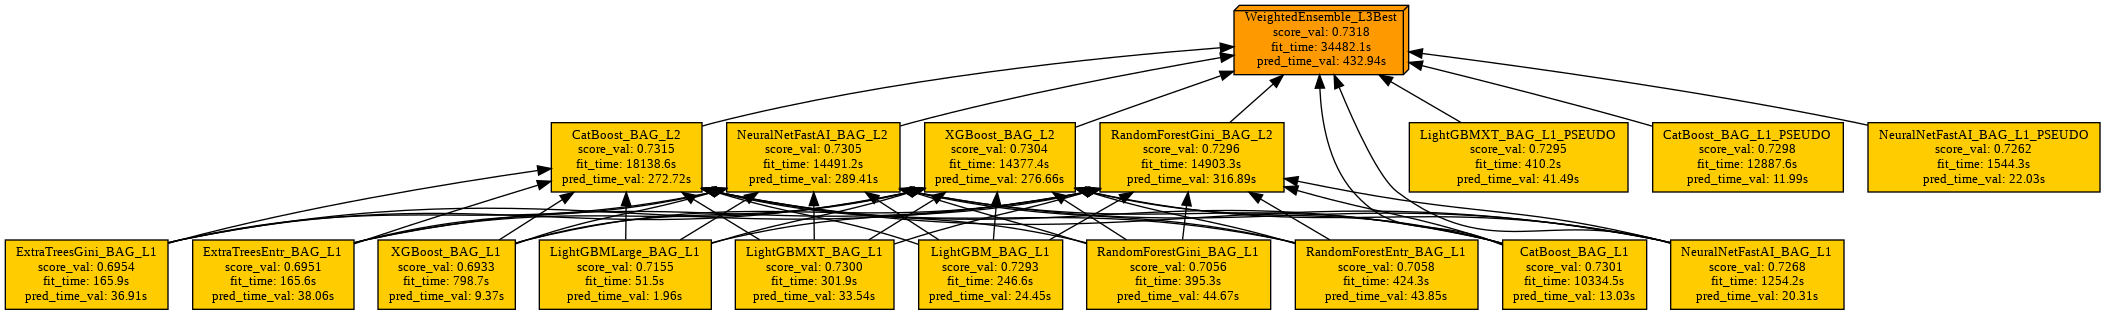

In [19]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image(f'{MODELS_PATH}ensemble_model.png'))

In [20]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
# !zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

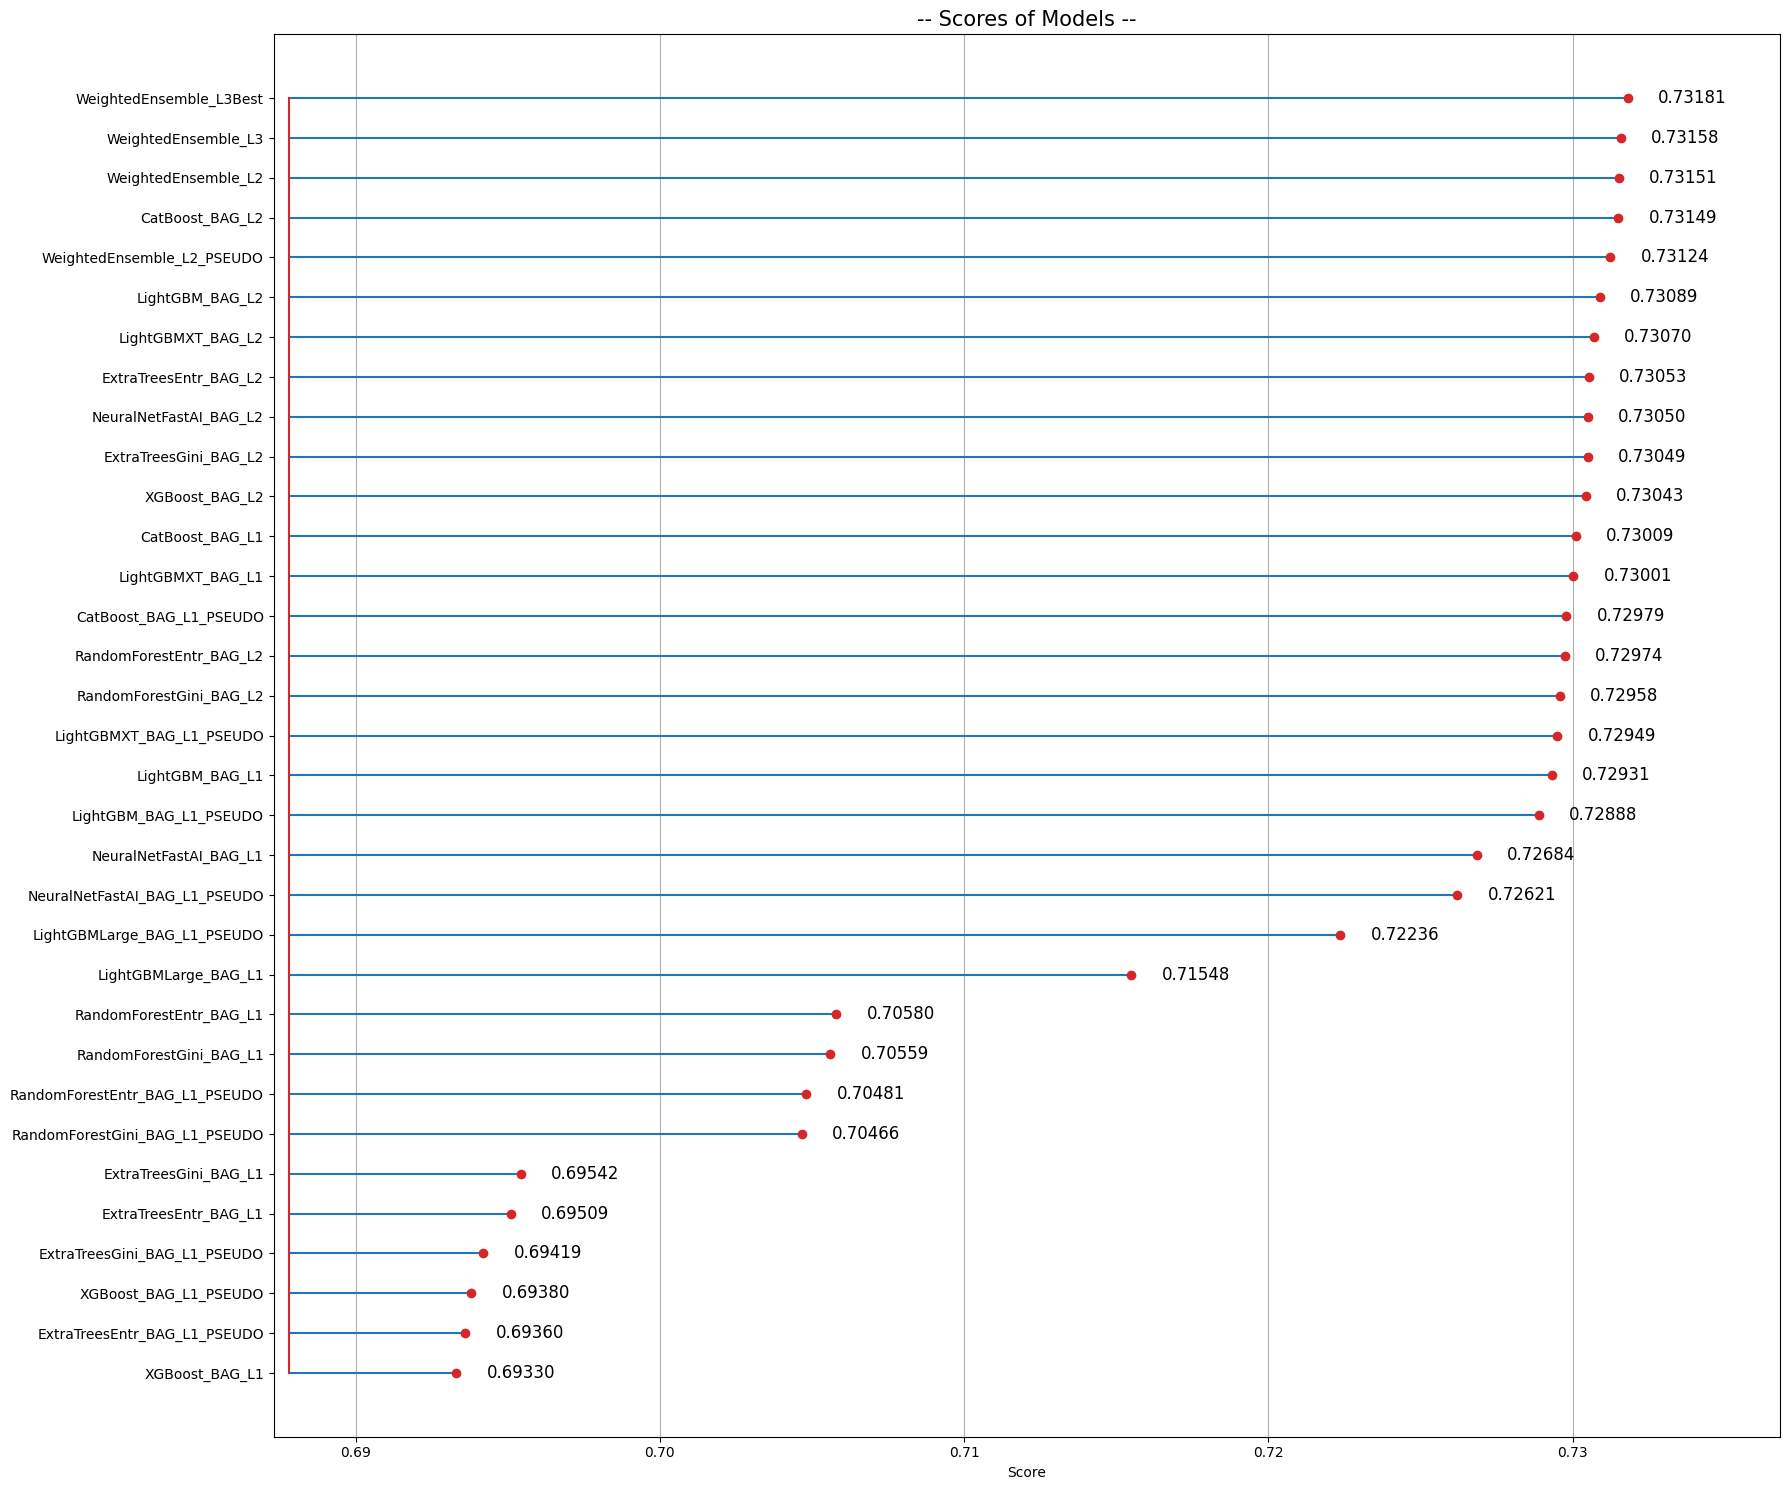

In [21]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score')
plt.title('-- Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [22]:
# predictor.model_names()

In [23]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [24]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------



In [25]:
## -- OPTIONAL: Remove stored files --
!rm -r {MODELS_PATH}